# Transfer learning and fine-tuning

Neste tutorial, você aprenderá como classificar imagens de cães e gatos usando aprendizagem por transferência de uma rede pré-treinada.

Um modelo pré-treinado é uma rede salva que foi previamente treinada em um grande conjunto de dados, normalmente em uma tarefa de classificação de imagens em grande escala. Você pode usar o modelo pré-treinado como está ou usar o aprendizado de transferência para personalizar esse modelo para uma determinada tarefa.

A intuição por trás da aprendizagem por transferência para classificação de imagens é que se um modelo for treinado em um conjunto de dados grande e geral o suficiente, esse modelo servirá efetivamente como um modelo genérico do mundo visual. Você pode então aproveitar as vantagens desses mapas de recursos aprendidos sem precisar começar do zero, treinando um modelo grande em um grande conjunto de dados.

Neste notebook, você tentará duas maneiras de personalizar um modelo pré-treinado:

1. Extração de recursos: Use as representações aprendidas por uma rede anterior para extrair recursos significativos de novas amostras. Você simplesmente adiciona um novo classificador, que será treinado do zero, sobre o modelo pré-treinado para que possa redirecionar os mapas de recursos aprendidos anteriormente para o conjunto de dados.

 Você não precisa (re) treinar o modelo inteiro. A rede convolucional básica já contém recursos que são genericamente úteis para classificar imagens. No entanto, a parte final de classificação do modelo pré-treinado é específica para a tarefa de classificação original e, posteriormente, específica para o conjunto de classes nas quais o modelo foi treinado.

1. Ajuste fino: descongele algumas das camadas superiores de uma base de modelo congelada e treine em conjunto as camadas classificadoras recém-adicionadas e as últimas camadas do modelo base. Isso nos permite “ajustar” as representações de recursos de ordem superior no modelo base para torná-las mais relevantes para a tarefa específica.

Você seguirá o fluxo de trabalho geral de aprendizado de máquina.

1. Examine e compreenda os dados
1. Construa um pipeline de entrada, neste caso usando Keras ImageDataGenerator
1. Componha o modelo
   * Carregar no modelo base pré-treinado (e pesos pré-treinados)
   * Empilhe as camadas de classificação por cima
1. Treine o modelo
1. Avalie o modelo


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Pré-processamento de dados

### Download de dados

Neste tutorial, você usará um conjunto de dados contendo milhares de imagens de cães e gatos. Baixe e extraia um arquivo zip contendo as imagens e, em seguida, crie um `tf.data.Dataset` para treinamento e validação usando o utilitário `tf.keras.utils.image_dataset_from_directory`.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Mostre as primeiras nove imagens e rótulos do conjunto de treinamento:

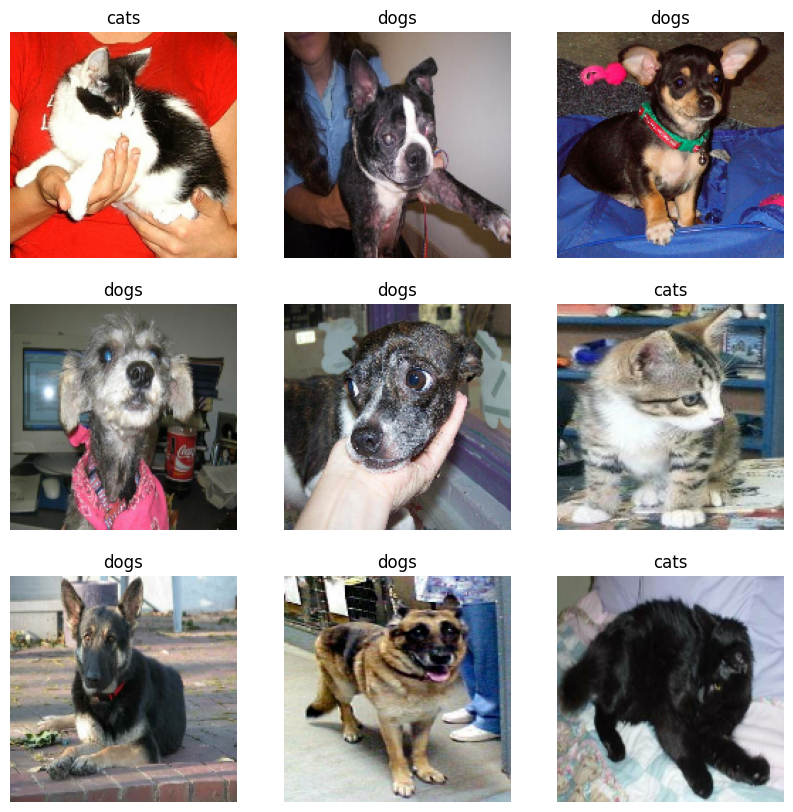

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Como o conjunto de dados original não contém um conjunto de testes, você criará um. Para fazer isso, determine quantos lotes de dados estão disponíveis no conjunto de validação usando `tf.data.experimental.cardinality` e, em seguida, mova 20% deles para um conjunto de teste.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure o conjunto de dados para desempenho

Use a pré-busca em buffer para carregar imagens do disco sem bloquear a E/S.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use aumento de dados

Quando você não tem um grande conjunto de dados de imagens, é uma boa prática introduzir artificialmente a diversidade de amostras aplicando transformações aleatórias, mas realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento e a reduzir o overfitting

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Nota: Essas camadas ficam ativas apenas durante o treinamento, quando você chama `Model.fit`. Eles ficam inativos quando o modelo é usado no modo de inferência em `Model.evaluate`, `Model.predict` ou `Model.call`.

Vamos aplicar essas camadas repetidamente na mesma imagem e ver o resultado.

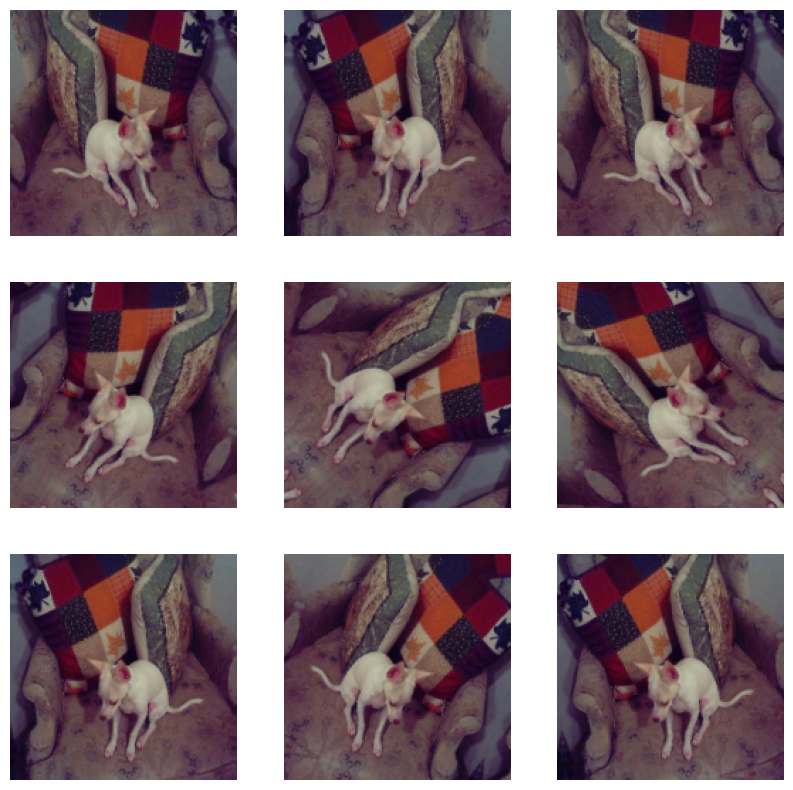

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Redimensionar valores de pixel

Em um momento, você fará download de `tf.keras.applications.MobileNetV2` para usar como modelo base. Este modelo espera valores de pixel em `[-1, 1]`, mas neste ponto, os valores de pixel em suas imagens estão em `[0, 255]`. Para redimensioná-los, use o método de pré-processamento incluído no modelo.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Nota: Alternativamente, você pode redimensionar os valores de pixel de `[0, 255]` para `[-1, 1]` usando `tf.keras.layers.Rescaling`.

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Nota: Se estiver usando outro `tf.keras.applications`, certifique-se de verificar o documento da API para determinar se eles esperam pixels em `[-1, 1]` ou `[0, 1]`, ou use o `preprocess_input incluído `função.

## Crie o modelo base a partir das convnets pré-treinadas
Você criará o modelo básico a partir do modelo **MobileNet V2** desenvolvido no Google. Isso é pré-treinado no conjunto de dados ImageNet, um grande conjunto de dados que consiste em 1,4 milhão de imagens e 1.000 classes. ImageNet é um conjunto de dados de treinamento em pesquisa com uma ampla variedade de categorias como `jaca` e `seringa`. Esta base de conhecimento nos ajudará a classificar cães e gatos em nosso conjunto de dados específico.

Primeiro, você precisa escolher qual camada do MobileNet V2 usará para extração de recursos. A última camada de classificação (em "topo", já que a maioria dos diagramas de modelos de aprendizado de máquina vão de baixo para cima) não é muito útil. Em vez disso, você seguirá a prática comum de depender da última camada antes da operação de nivelamento. Essa camada é chamada de “camada gargalo”. Os recursos da camada gargalo retêm mais generalidade em comparação com a camada final/superior.

Primeiro, instancie um modelo MobileNet V2 pré-carregado com pesos treinados no ImageNet. Ao especificar o argumento **include_top=False**, você carrega uma rede que não inclui as camadas de classificação na parte superior, o que é ideal para extração de recursos.

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Este extrator de recursos converte cada imagem `160x160x3` em um bloco de recursos `5x5x1280`. Vamos ver o que isso faz com um exemplo de lote de imagens:

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Extração de recursos
Nesta etapa, você irá congelar a base convolucional criada na etapa anterior e usá-la como extrator de recursos. Além disso, você adiciona um classificador sobre ele e treina o classificador de nível superior.

### Congelar a base convolucional

É importante congelar a base convolucional antes de compilar e treinar o modelo. O congelamento (definindo layer.trainable = False) evita que os pesos de uma determinada camada sejam atualizados durante o treinamento. O MobileNet V2 tem muitas camadas, portanto, definir o sinalizador `treinável` de todo o modelo como False irá congelar todas elas.

In [15]:
base_model.trainable = False

### Nota importante sobre camadas de BatchNormalization

Muitos modelos contêm camadas `tf.keras.layers.BatchNormalization`. Esta camada é um caso especial e devem ser tomadas precauções no contexto do ajuste fino, conforme mostrado mais adiante neste tutorial.

Quando você define `layer.trainable = False`, a camada `BatchNormalization` será executada no modo de inferência e não atualizará suas estatísticas de média e variância.

Ao descongelar um modelo que contém camadas BatchNormalization para fazer o ajuste fino, você deve manter as camadas BatchNormalization no modo de inferência passando `training = False` ao chamar o modelo base. Caso contrário, as atualizações aplicadas aos pesos não treináveis ​​destruirão o que o modelo aprendeu.


In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Adicione um cabeçalho de classificação

Para gerar previsões a partir do bloco de recursos, faça a média das localizações espaciais `5x5`, usando uma camada `tf.keras.layers.GlobalAveragePooling2D` para converter os recursos em um único vetor de 1280 elementos por imagem.

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique uma camada `tf.keras.layers.Dense` para converter esses recursos em uma única previsão por imagem. Você não precisa de uma função de ativação aqui porque esta previsão será tratada como um `logit` ou um valor bruto de previsão. Os números positivos predizem a classe 1, os números negativos predizem a classe 0.

In [18]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Crie um modelo encadeando as camadas de aumento de dados, reescalonamento, `base_model` e extrator de recursos usando a API Keras Functional. Como mencionado anteriormente, use `training=False` pois nosso modelo contém uma camada `BatchNormalization`.

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Os mais de 8 milhões de parâmetros no MobileNet estão congelados, mas existem 1,2 mil parâmetros _treináveis_ na camada Densa. Eles são divididos entre dois objetos `tf.Variable`, os pesos e as tendências.

In [21]:
len(model.trainable_variables)

2

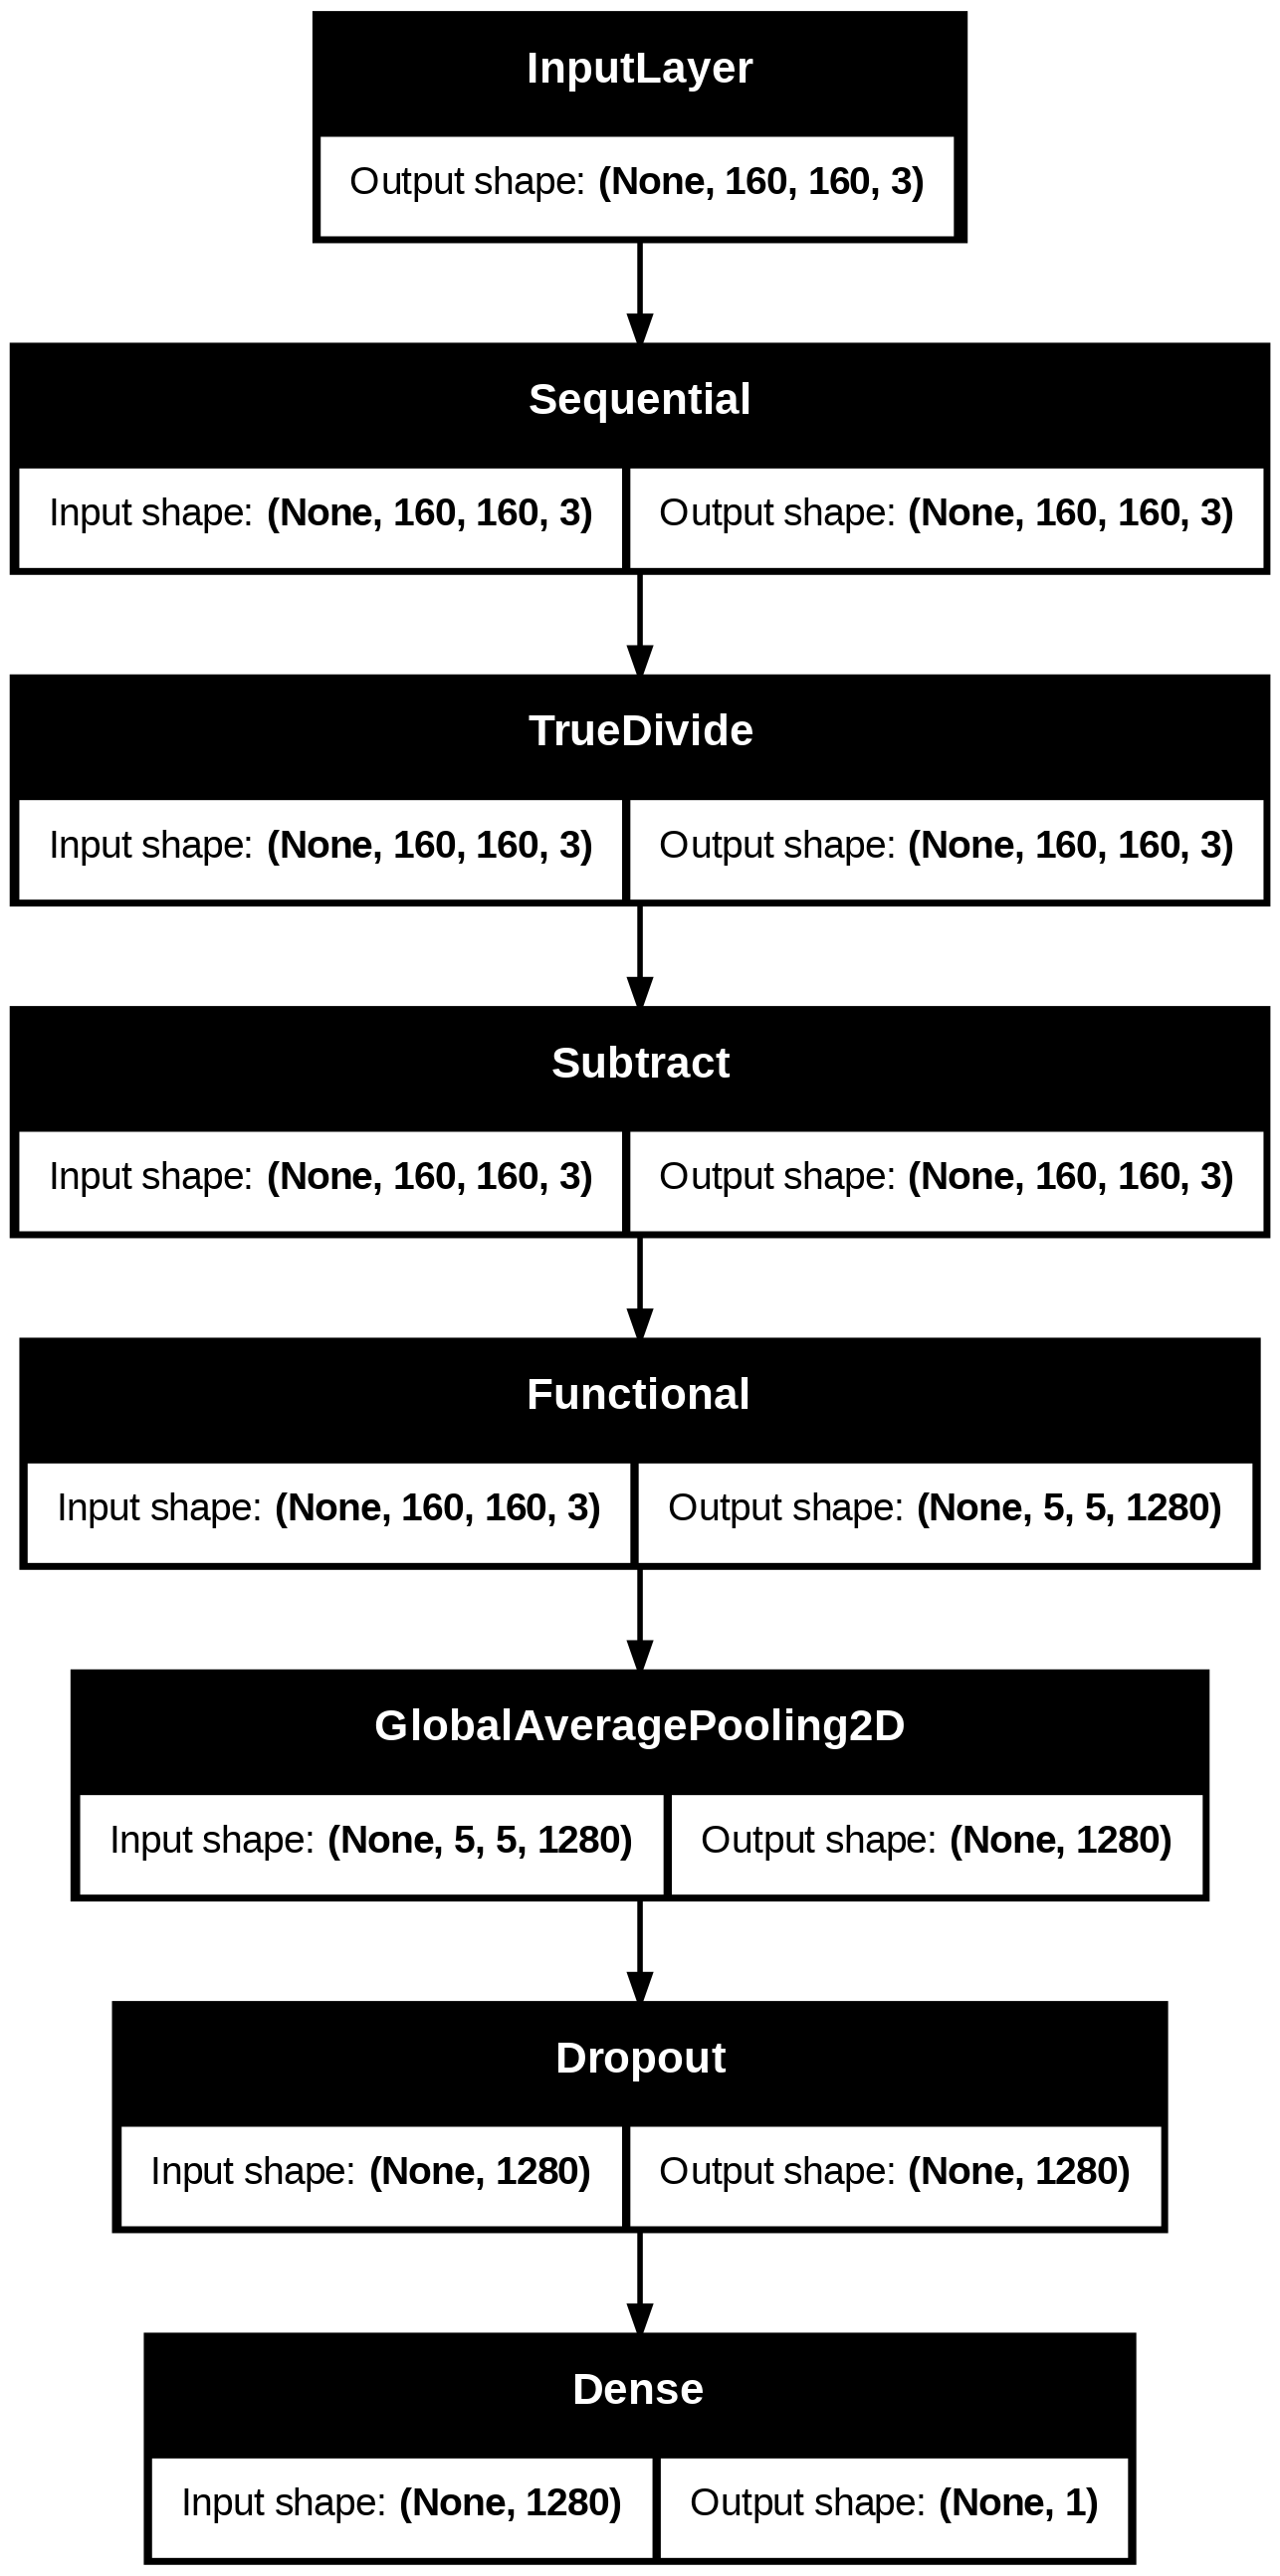

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile o modelo

Compile o modelo antes de treiná-lo. Como existem duas classes e uma saída sigmóide, use `BinaryAccuracy`.

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Treine o modelo

Após treinar por 10 épocas, você deverá ver uma precisão de aproximadamente 96% no conjunto de validação.

In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4468 - loss: 0.8303


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.47


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5828 - loss: 0.7289 - val_accuracy: 0.7401 - val_loss: 0.5456
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7236 - loss: 0.5448 - val_accuracy: 0.8800 - val_loss: 0.4003
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8297 - loss: 0.4215 - val_accuracy: 0.9257 - val_loss: 0.3153
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8441 - loss: 0.3633 - val_accuracy: 0.9443 - val_loss: 0.2517
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8681 - loss: 0.3241 - val_accuracy: 0.9517 - val_loss: 0.2207
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8943 - loss: 0.2757 - val_accuracy: 0.9616 - val_loss: 0.1834
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9017 - loss: 0.2558 - val_accuracy: 0.9653 - val_loss: 0.1649
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9060 - loss: 0.2418 - val_accuracy: 0.9629 - 

### Curvas de aprendizado

Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e validação ao usar o modelo base MobileNetV2 como um extrator de recursos fixos.

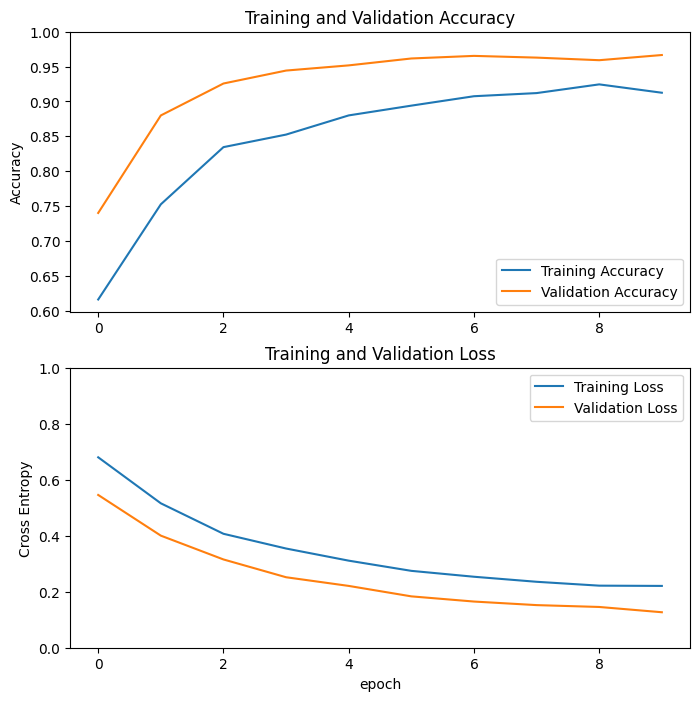

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Nota: Se você está se perguntando por que as métricas de validação são claramente melhores que as métricas de treinamento, o principal fator é porque camadas como `tf.keras.layers.BatchNormalization` e `tf.keras.layers.Dropout` afetam a precisão durante o treinamento. Eles são desligados ao calcular a perda de validação.

Em menor grau, isso também ocorre porque as métricas de treinamento relatam a média de uma época, enquanto as métricas de validação são avaliadas após a época, portanto, as métricas de validação veem um modelo que treinou um pouco mais.

## Afinação
No experimento de extração de recursos, você treinou apenas algumas camadas sobre um modelo base MobileNetV2. Os pesos da rede pré-treinada **não** foram atualizados durante o treinamento.

Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores do modelo pré-treinado junto com o treinamento do classificador que você adicionou. O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para recursos associados especificamente ao conjunto de dados.

Nota: Isso só deve ser tentado depois de você ter treinado o classificador de nível superior com o modelo pré-treinado definido como não treinável. Se você adicionar um classificador inicializado aleatoriamente em cima de um modelo pré-treinado e tentar treinar todas as camadas em conjunto, a magnitude das atualizações de gradiente será muito grande (devido aos pesos aleatórios do classificador) e seu modelo pré-treinado irá esqueça o que aprendeu.

Além disso, você deve tentar ajustar um pequeno número de camadas superiores em vez de todo o modelo MobileNet. Na maioria das redes convolucionais, quanto mais alta uma camada, mais especializada ela é. As primeiras camadas aprendem recursos muito simples e genéricos que se generalizam para quase todos os tipos de imagens. À medida que você sobe, os recursos são cada vez mais específicos do conjunto de dados no qual o modelo foi treinado. O objetivo do ajuste fino é adaptar esses recursos especializados para funcionarem com o novo conjunto de dados, em vez de substituir o aprendizado genérico.

### Descongele as camadas superiores do modelo

Tudo o que você precisa fazer é descongelar o base_model e definir as camadas inferiores como não treináveis. Em seguida, você deve recompilar o modelo (necessário para que essas alterações tenham efeito) e retomar o treinamento.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile o modelo

Como você está treinando um modelo muito maior e deseja readaptar os pesos pré-treinados, é importante utilizar uma taxa de aprendizado menor nesta fase. Caso contrário, seu modelo poderá se ajustar muito rapidamente.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [32]:
len(model.trainable_variables)

56

### Continue treinando o modelo

Se você treinou para convergência anteriormente, esta etapa melhorará sua precisão em alguns pontos percentuais.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8053 - loss: 0.4033 - val_accuracy: 0.9703 - val_loss: 0.0919
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8922 - loss: 0.2615 - val_accuracy: 0.9765 - val_loss: 0.0765
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9143 - loss: 0.2182 - val_accuracy: 0.9827 - val_loss: 0.0572
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9262 - loss: 0.1887 - val_accuracy: 0.9814 - val_loss: 0.0588
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9356 - loss: 0.1775 - val_accuracy: 0.9851 - val_loss: 0.0465
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9413 - loss: 0.1425 - val_accuracy: 0.9889 - val_loss: 0.0431
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9484 - loss: 0.1360 - val_accuracy: 0.9889 - val_loss: 0.0442
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9562 - loss: 0.1098 - val_accuracy: 

Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e validação ao ajustar as últimas camadas do modelo base MobileNetV2 e treinar o classificador sobre ele. A perda de validação é muito maior que a perda de treinamento, então você pode obter algum overfitting.

Você também pode obter algum overfitting, pois o novo conjunto de treinamento é relativamente pequeno e semelhante aos conjuntos de dados MobileNetV2 originais.

Após o ajuste fino, o modelo atinge quase 98% de precisão no conjunto de validação.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

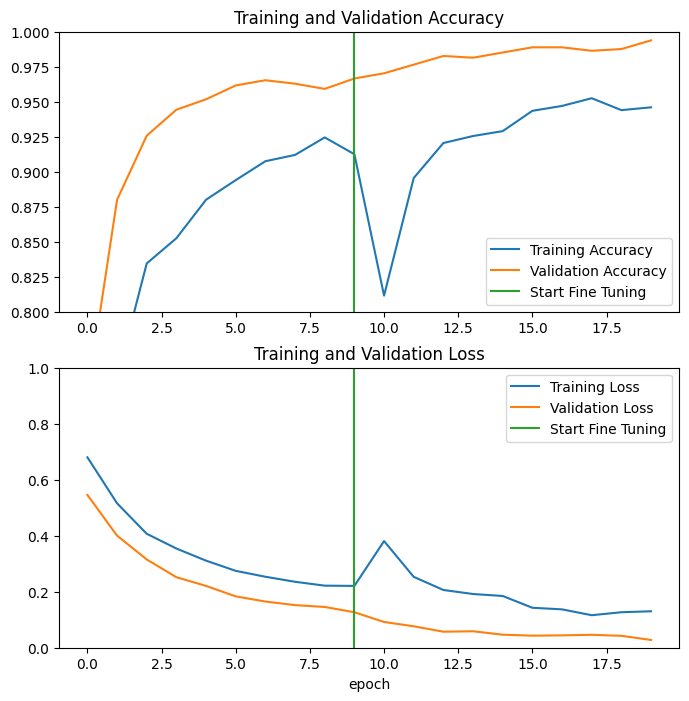

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Avaliação e previsão

Finalmente, você pode verificar o desempenho do modelo em novos dados usando o conjunto de testes.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9976 - loss: 0.0294
Test accuracy : 0.9947916865348816


E agora você está pronto para usar este modelo para prever se seu animal de estimação é um gato ou um cachorro.

Predictions:
 [1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1]
Labels:
 [1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1]


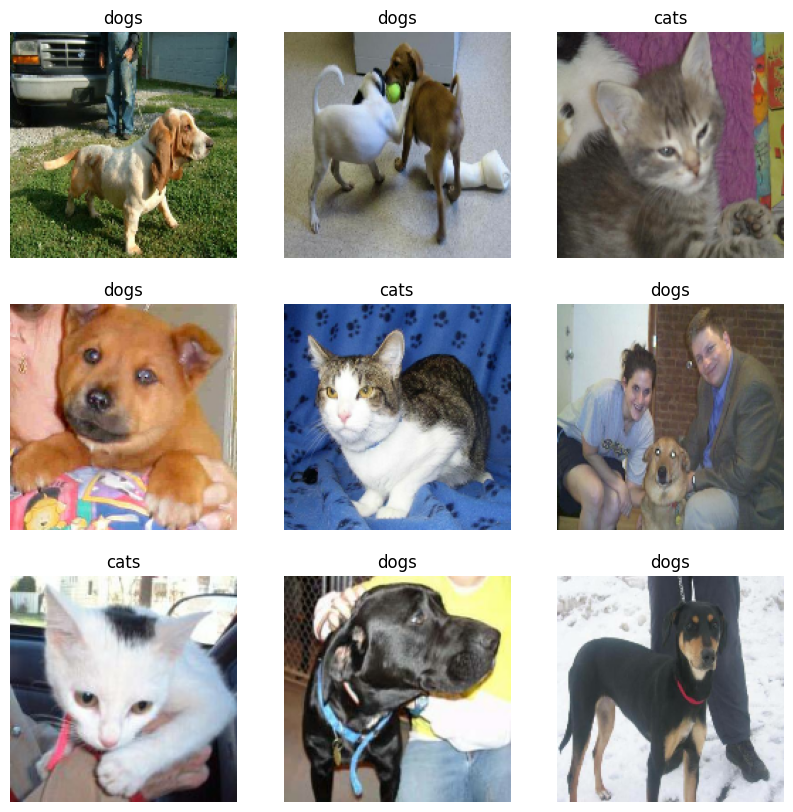

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Resumo

* **Uso de um modelo pré-treinado para extração de recursos**: ao trabalhar com um conjunto de dados pequeno, é uma prática comum aproveitar os recursos aprendidos por um modelo treinado em um conjunto de dados maior no mesmo domínio. Isso é feito instanciando o modelo pré-treinado e adicionando um classificador totalmente conectado no topo. O modelo pré-treinado fica “congelado” e apenas os pesos do classificador são atualizados durante o treinamento.
Nesse caso, a base convolucional extraiu todos os recursos associados a cada imagem e você apenas treinou um classificador que determina a classe da imagem dado aquele conjunto de recursos extraídos.

* **Ajustando um modelo pré-treinado**: para melhorar ainda mais o desempenho, pode-se querer redirecionar as camadas de nível superior dos modelos pré-treinados para o novo conjunto de dados por meio de ajuste fino.
Nesse caso, você ajustou seus pesos de forma que seu modelo aprendesse recursos de alto nível específicos do conjunto de dados. Essa técnica geralmente é recomendada quando o conjunto de dados de treinamento é grande e muito semelhante ao conjunto de dados original no qual o modelo pré-treinado foi treinado.
